In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    virtual_scan,
    mesh_depth_image,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
)

In [ ]:
import numpy as np

def generate_rgbd_noise(
    verts_img: np.ndarray,                 # (H,W,3) or (N,3); may contain inf/NaN
    cam_centre: np.ndarray | tuple,
    look_dir:   np.ndarray | tuple,
    normals_img: np.ndarray | None = None, # same layout as verts if provided
    *,
    # axial noise model: sigma_z = (alpha*d + beta*d^2) * (1 + lambda*(1-cos(theta)))
    alpha: float = 2e-4,
    beta:  float = 2e-4,
    grazing_lambda: float = 1.0,
    sigma_floor: float = 1e-4,            # meters; avoid huge weights
    # optional low-frequency radial bias (kept out of sigma)
    bias_k1: float = 0.0,                 # 0 disables; try 0.01–0.02 for mild bow
    fov_deg: float = 70.0,
    seed: int | None = None,
):
    """
    Returns:
      verts_noised : same shape as verts_img, with inf/NaN preserved at original pixels
      weights      : (H,W) if input is (H,W,3), else (N,), precision along ray; 0 for invalid
    """
    rng = np.random.default_rng(seed)

    V = np.asarray(verts_img)
    orig_dtype = V.dtype
    is_image = (V.ndim == 3)

    # Flatten to (N,3) view; we'll write back into a copy
    V_flat = V.reshape(-1, 3).astype(np.float64, copy=False)

    # A vertex is valid iff all 3 components are finite
    valid = np.isfinite(V_flat).all(axis=1)
    if not np.any(valid):
        # Nothing to do
        weights = np.zeros(V.shape[:2] if is_image else (V_flat.shape[0],), dtype=np.float32)
        return V.copy(), weights

    Vv = V_flat[valid]

    # Normals: optional, aligned to verts; select the same valid subset
    if normals_img is not None:
        N_in = np.asarray(normals_img).reshape(-1, 3)
        Nv = N_in[valid].astype(np.float64, copy=False)
    else:
        Nv = None

    # Camera vectors
    C = np.asarray(cam_centre, dtype=np.float64).reshape(1, 3)
    L = np.asarray(look_dir,   dtype=np.float64).reshape(3)
    L /= (np.linalg.norm(L) + 1e-12)

    # Geometry for valid points
    R  = Vv - C                             # camera -> point
    d  = R @ L                              # depth along camera forward
    d  = np.maximum(d, 0.0)
    Rn = np.linalg.norm(R, axis=1, keepdims=True)
    ray_dir = R / np.maximum(Rn, 1e-12)     # per-pixel viewing ray (unit)

    # Grazing term
    if Nv is not None:
        Nv = Nv / (np.linalg.norm(Nv, axis=1, keepdims=True) + 1e-12)
        cos_th = np.abs(np.sum(Nv * (-ray_dir), axis=1))
    else:
        cos_th = np.abs(ray_dir @ (-L))
    grazing_boost = 1.0 + grazing_lambda * (1.0 - cos_th)

    # Axial std dev (meters)
    sigma_z = (alpha * d + beta * (d ** 2)) * grazing_boost
    sigma_z = np.maximum(sigma_z, sigma_floor)

    # Sample zero-mean axial noise
    n_ax = rng.normal(0.0, sigma_z)
    disp = n_ax[:, None] * ray_dir

    # Optional simple radial bias (kept out of sigma/weights)
    if bias_k1 != 0.0:
        # Build (right, up) camera basis
        up_guess = np.array([0.0, 1.0, 0.0], dtype=np.float64)
        if abs(np.dot(up_guess, L)) > 0.95:
            up_guess = np.array([0.0, 0.0, 1.0], dtype=np.float64)
        right = np.cross(L, up_guess); right /= (np.linalg.norm(right) + 1e-12)
        up    = np.cross(right, L)

        denom = d + 1e-12
        x = (R @ right) / denom
        y = (R @ up)    / denom
        scale = np.tan(np.deg2rad(fov_deg) * 0.5)
        xn, yn = x / scale, y / scale
        r2 = xn * xn + yn * yn

        disp += (bias_k1 * d * r2)[:, None] * ray_dir

    # Write back into a copy, preserving invalid pixels as-is (inf/NaN)
    V_out = V_flat.copy()
    V_out[valid] = (Vv + disp).astype(orig_dtype, copy=False)
    V_out = V_out.reshape(V.shape)

    # Per-vertex precision from axial jitter only; 0 for invalid
    w = np.zeros(V_flat.shape[0], dtype=np.float32)
    w[valid] = (1.0 / (sigma_z ** 2)).astype(np.float32)

    weights = w.reshape(V.shape[:2] if is_image else (-1,))
    return V_out, weights


In [4]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
)

meshes = dict()
for foldername,filename in names:
    print(f'Getting the {filename.split('.')[0]}')
    
    mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(mesh)
    mesh.compute_vertex_normals()

    meshes[foldername] = mesh

meshlist = list(meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill


In [5]:
centres = []
for meshname, mesh in meshes.items():
    if meshname == 'table':
        continue
    centres.append(mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [6]:
mesh: o3d.geometry.TriangleMesh = meshlist
cam_centre=polar2cartesian(1.0, 30, 90)
look_at=obj_centre
width_px: int = 360
height_px: int = 240
fov: float = 70.0
k: float = 3.5
max_normal_angle_deg = None

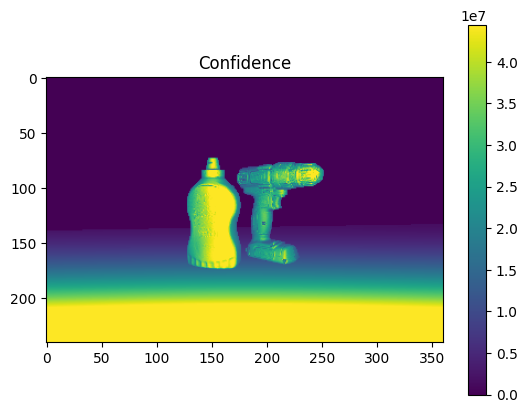

In [7]:
mesh_scans = list()
for i in range(2):
    scan_result = virtual_scan(
        meshlist,
        cam_centre,
        look_at,
        width_px=width_px,
        height_px=height_px,
        fov=fov,
    )

    look_dir   = obj_centre - cam_centre
    look_dir   = look_dir / np.linalg.norm(look_dir)

    verts_noised, weights = generate_rgbd_noise(
        verts_img=scan_result['verts'],
        cam_centre=cam_centre,
        look_dir=look_dir,
        normals_img=scan_result['norms'],
        
        alpha = 0.0002,         # linear depth term (≈ 2% of depth)
        beta  = 0.0002,         # quadratic depth term
        grazing_lambda = 1.0,   # boosts σ at grazing angles; 0 disables
        sigma_floor = 0.00015,  # prevents infinite weights
        # --- optional low-frequency radial bias (image-plane) ---
        bias_k1 =  0.0,         # e.g., 0.01–0.03 for mild bowing
        fov_deg = 70.0,         # only needed if bias_k1 != 0
        seed = None,
    )

    # pcd1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(valid_verts))
    # pcd1.paint_uniform_color(np.array([1, 0, 0]))
    # pcd2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(valid_verts_noised))
    # pcd2.paint_uniform_color(np.array([0, 1, 0]))

    # o3d.visualization.draw_geometries([pcd1, pcd2])

    mesh, trimmed_weights = mesh_depth_image(
        points=verts_noised,
        weights=weights,
        vertex_colours=scan_result['vcols'],
        cam_centre=cam_centre,
        segmentation=scan_result['segmt'],
        normals=scan_result['norms'],
        k=3.5,
        max_normal_angle_deg=max_normal_angle_deg,
    )

    mesh.remove_non_manifold_edges()
    mesh.remove_unreferenced_vertices()
    mesh.remove_degenerate_triangles()
    mesh.remove_duplicated_triangles()
    mesh.compute_vertex_normals()

    mesh_scans.append((mesh, trimmed_weights))
    


# plt.title('Uncertainty')
# plt.imshow(np.flip(1/np.sqrt(weights)))
plt.title('Confidence')
plt.imshow(np.flip(weights))
plt.colorbar()

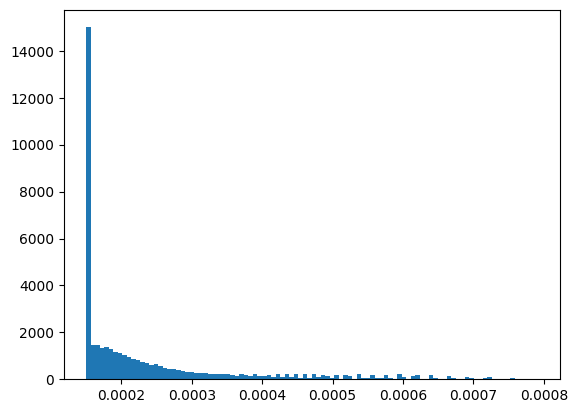

In [8]:
# _ = plt.hist((1/np.sqrt(weights[weights!=0])).reshape(-1),bins=100)
_ = plt.hist((1/np.sqrt(trimmed_weights[trimmed_weights!=0])).reshape(-1),bins=100)

In [9]:
o3d.visualization.draw_geometries([mesh_scan[0] for mesh_scan in mesh_scans])

In [10]:
pcd = o3d.geometry.PointCloud(mesh.vertices)
nrm_wts = trimmed_weights / trimmed_weights.max()
colours_np = np.concatenate([nrm_wts[:,None], 1-nrm_wts[:,None], np.zeros((len(nrm_wts),1))], axis=1)
colours_np = np.concatenate([
    nrm_wts[:,None],
    1-nrm_wts[:,None],
    # 1-nrm_wts[:,None],
    np.ones((len(nrm_wts),1))], axis=1)
pcd.colors = o3d.utility.Vector3dVector(colours_np)
o3d.visualization.draw_geometries([pcd])

In [11]:
weights1 = mesh_scans[0][1]
weights2 = mesh_scans[1][1]

np.concatenate((weights1, weights2)).shape

(84213,)

In [14]:
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)

fused_mesh, fused_weights = fuse_meshes(
    mesh1           = mesh_scans[0][0],
    weights1        = mesh_scans[0][1],
    mesh2           = mesh_scans[1][0],
    weights2        = mesh_scans[1][1],
    h_alpha         = 2.5,
    r_alpha         = 2.0,
    nrm_shift_iters = 2,
    nrm_smth_iters  = 1,
    shift_all       = False,
    fill_holes      = False,
)

/Users/christopher/Documents/Coding/Imperial/MSc Project/MSc-Project/src/superprimitive_fusion/mesh_fusion_utils.py:352: RuntimeWarning: divide by zero encountered in divide
  w_normal = np.exp(-(1.0 - cos_theta) / (2.0 * sigma_c))


[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.
[WARN; vertex smoother] Using w_density=1.0 as sigma_rho < rho_floor.


In [15]:
o3d.visualization.draw_geometries([fused_mesh])